In [175]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import string
from conllu import parse

In [106]:
with open("UD_English-Atis/en_atis-ud-train.conllu", "r", encoding="utf-8") as f:
    data = f.read()
    train_sentences = parse(data)
    
with open("UD_English-Atis/en_atis-ud-dev.conllu", "r", encoding="utf-8") as f:
    data = f.read()
    dev_sentences = parse(data)
    
with open("UD_English-Atis/en_atis-ud-test.conllu", "r", encoding="utf-8") as f:
    data = f.read()
    test_sentences = parse(data)
    
tokens = []
for sentence in train_sentences:
    for token in sentence:
        tokens.append(token)

In [107]:
df = pd.DataFrame(tokens)

In [108]:
pos_class = {token: idx for idx, token in enumerate(df['upos'].unique())}
pos_class_rev = {idx: token for idx, token in enumerate(df['upos'].unique())}
vocab = df['form'].unique()
START_TOKEN = "<s>"
END_TOKEN = "</s>"
UNKNOWN_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"
vocab = np.append(vocab, [START_TOKEN, END_TOKEN, UNKNOWN_TOKEN, PAD_TOKEN])
vocab = {token: idx for idx, token in enumerate(vocab)}

In [173]:
class CustomDataset(Dataset):
    def __init__(self, data, p = 1, s = 1):
        self.data = data
        self.p = p
        self.s = s
        tokens = []
        start = {'form': START_TOKEN}
        end = {'form': END_TOKEN}
        start_tokens = [start for _ in range(p)]
        end_tokens = [end for _ in range(s)]
        for sentence in self.data:
            tokens += start_tokens
            for token in sentence:
                tokens.append(token)
            tokens += end_tokens
        self.df = pd.DataFrame(tokens)
        self.data = self.df[(self.df['form'] != START_TOKEN) & (self.df['form'] != END_TOKEN) & (self.df['upos'].isin(pos_class))].index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        target = self.df.iloc[self.data[idx]]
        previous_tokens = self.df.iloc[self.data[idx]-self.p:self.data[idx]]
        next_tokens = self.df.iloc[self.data[idx]+1:self.data[idx]+self.s+1]
        ret = [vocab[token] if token in vocab else vocab[UNKNOWN_TOKEN] for token in previous_tokens['form']]
        ret.append(vocab[target['form']] if target['form'] in vocab else vocab[UNKNOWN_TOKEN])
        ret += [vocab[token] if token in vocab else vocab[UNKNOWN_TOKEN] for token in next_tokens['form']]
        return torch.tensor(ret), pos_class[target['upos']]

def tokenize(input_sentence, p = 1, s = 1):
    tokens = word_tokenize(input_sentence)
    tokens = [token.lower() for token in tokens if token not in string.punctuation]
    test_tokens = [vocab[START_TOKEN]]*p + [vocab[token] if token in vocab else vocab[UNKNOWN_TOKEN] for token in tokens]+ [vocab[END_TOKEN]]*s
    ret = []
    for token in range(len(test_tokens)-s-p):
        ret.append(test_tokens[token:token+p+s+1])
    return torch.tensor(ret)

In [120]:
class FeedForwardNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_layers, hidden_dims, output_dim, activation = 'relu', p = 1, s = 1):
        super(FeedForwardNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layers = nn.ModuleList([])
        input_dim = (p+s+1)*embedding_dim
        
        for layer in range(hidden_layers):
            self.layers.append(nn.Linear(input_dim, hidden_dims[layer]))
            input_dim = hidden_dims[layer]
            
        self.final_layer = nn.Linear(hidden_dims[-1], output_dim)
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            self.activation = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x).reshape(len(x),-1)
        for layer in self.layers:
            embedded = self.activation(layer(embedded))
        output = self.final_layer(embedded)
        return output
    
    def predict(self, x):
        out = self.forward(x)
        return torch.argmax(self.softmax(out), axis = 1)

In [166]:
num_epochs = 10
embedding_dims = 100
context_size = [1,2,3,4]
hidden_layers = [1,2]
hidden_dims = [[64], [64,32]]
activations = ['relu', 'tanh']
params_acc = []

for context in context_size:
    train_data = CustomDataset(train_sentences, p = context, s = context)
    dev_data = CustomDataset(dev_sentences, p = context, s = context)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    dev_loader = DataLoader(dev_data, batch_size=32, shuffle=False)

    for idx,layers in enumerate(hidden_layers):
        for act_idx, activation in enumerate(activations):
            model = FeedForwardNN(len(vocab), embedding_dims,layers, hidden_dims[idx], len(pos_class),activation = activation, p = context, s = context)
            loss_function = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)

            model.train()
            best_acc = 0
            for epoch in range(num_epochs):
                net_loss = 0
                for x, y in train_loader:
                    optimizer.zero_grad()
                    output = model(x)
                    loss = loss_function(output, y)
                    loss.backward()
                    net_loss += loss
                    optimizer.step()

                with torch.no_grad():
                    acc = 0
                    for x, y in dev_loader:
                        predict = model.predict(x)
                        accuracy = len(predict[predict ==  y]) / len(predict)
                        acc += accuracy
                        
                if(acc > best_acc):
                    best_acc = acc
                    torch.save(model.state_dict(), f'./ffn/model_{context}_{idx}_{act_idx}.pth')
                
                print(f"TRAIN [{epoch} | {num_epochs}]: Hidden_layers: {layers}, Activation: {activation}, Loss: {net_loss.item() / len(train_loader):.4f}")
                print(f"DEV [{epoch} | {num_epochs}]: Context Size: {context}, Hidden_layers: {layers}, Activation: {activation}, Accuracy: {acc / len(dev_loader):.4f}")
            
            params_acc.append([context, layers, activation, best_acc / len(dev_loader)])
            print('\n')
            
        
        

TRAIN [0 | 10]: Hidden_layers: 1, Activation: relu, Loss: 0.2623
DEV [0 | 10]: Context Size: 1, Hidden_layers: 1, Activation: relu, Accuracy: 0.9737
TRAIN [1 | 10]: Hidden_layers: 1, Activation: relu, Loss: 0.0697
DEV [1 | 10]: Context Size: 1, Hidden_layers: 1, Activation: relu, Accuracy: 0.9736
TRAIN [2 | 10]: Hidden_layers: 1, Activation: relu, Loss: 0.0487
DEV [2 | 10]: Context Size: 1, Hidden_layers: 1, Activation: relu, Accuracy: 0.9819
TRAIN [3 | 10]: Hidden_layers: 1, Activation: relu, Loss: 0.0382
DEV [3 | 10]: Context Size: 1, Hidden_layers: 1, Activation: relu, Accuracy: 0.9802
TRAIN [4 | 10]: Hidden_layers: 1, Activation: relu, Loss: 0.0342
DEV [4 | 10]: Context Size: 1, Hidden_layers: 1, Activation: relu, Accuracy: 0.9786
TRAIN [5 | 10]: Hidden_layers: 1, Activation: relu, Loss: 0.0321
DEV [5 | 10]: Context Size: 1, Hidden_layers: 1, Activation: relu, Accuracy: 0.9802
TRAIN [6 | 10]: Hidden_layers: 1, Activation: relu, Loss: 0.0293
DEV [6 | 10]: Context Size: 1, Hidden_lay

TRAIN [5 | 10]: Hidden_layers: 1, Activation: tanh, Loss: 0.0254
DEV [5 | 10]: Context Size: 2, Hidden_layers: 1, Activation: tanh, Accuracy: 0.9793
TRAIN [6 | 10]: Hidden_layers: 1, Activation: tanh, Loss: 0.0235
DEV [6 | 10]: Context Size: 2, Hidden_layers: 1, Activation: tanh, Accuracy: 0.9828
TRAIN [7 | 10]: Hidden_layers: 1, Activation: tanh, Loss: 0.0221
DEV [7 | 10]: Context Size: 2, Hidden_layers: 1, Activation: tanh, Accuracy: 0.9818
TRAIN [8 | 10]: Hidden_layers: 1, Activation: tanh, Loss: 0.0207
DEV [8 | 10]: Context Size: 2, Hidden_layers: 1, Activation: tanh, Accuracy: 0.9807
TRAIN [9 | 10]: Hidden_layers: 1, Activation: tanh, Loss: 0.0204
DEV [9 | 10]: Context Size: 2, Hidden_layers: 1, Activation: tanh, Accuracy: 0.9827


TRAIN [0 | 10]: Hidden_layers: 2, Activation: relu, Loss: 0.2823
DEV [0 | 10]: Context Size: 2, Hidden_layers: 2, Activation: relu, Accuracy: 0.9704
TRAIN [1 | 10]: Hidden_layers: 2, Activation: relu, Loss: 0.0768
DEV [1 | 10]: Context Size: 2, Hidden_l

TRAIN [0 | 10]: Hidden_layers: 2, Activation: tanh, Loss: 0.3059
DEV [0 | 10]: Context Size: 3, Hidden_layers: 2, Activation: tanh, Accuracy: 0.9678
TRAIN [1 | 10]: Hidden_layers: 2, Activation: tanh, Loss: 0.0803
DEV [1 | 10]: Context Size: 3, Hidden_layers: 2, Activation: tanh, Accuracy: 0.9740
TRAIN [2 | 10]: Hidden_layers: 2, Activation: tanh, Loss: 0.0497
DEV [2 | 10]: Context Size: 3, Hidden_layers: 2, Activation: tanh, Accuracy: 0.9770
TRAIN [3 | 10]: Hidden_layers: 2, Activation: tanh, Loss: 0.0360
DEV [3 | 10]: Context Size: 3, Hidden_layers: 2, Activation: tanh, Accuracy: 0.9734
TRAIN [4 | 10]: Hidden_layers: 2, Activation: tanh, Loss: 0.0300
DEV [4 | 10]: Context Size: 3, Hidden_layers: 2, Activation: tanh, Accuracy: 0.9795
TRAIN [5 | 10]: Hidden_layers: 2, Activation: tanh, Loss: 0.0267
DEV [5 | 10]: Context Size: 3, Hidden_layers: 2, Activation: tanh, Accuracy: 0.9798
TRAIN [6 | 10]: Hidden_layers: 2, Activation: tanh, Loss: 0.0234
DEV [6 | 10]: Context Size: 3, Hidden_lay

In [167]:
dev_performance = pd.DataFrame(params_acc, columns = ['Context Size','Hidden Layers', 'Activation', 'Accuracy']).sort_values('Accuracy', ascending = False)
dev_performance

,Context Size,Hidden Layers,Activation,Accuracy
2,1,2,relu,0.982873
5,2,1,tanh,0.982756
1,1,1,tanh,0.982572
7,2,2,tanh,0.982305
0,1,1,relu,0.981888
4,2,1,relu,0.981587
3,1,2,tanh,0.980919
9,3,1,tanh,0.980803
11,3,2,tanh,0.980803
13,4,1,tanh,0.979901


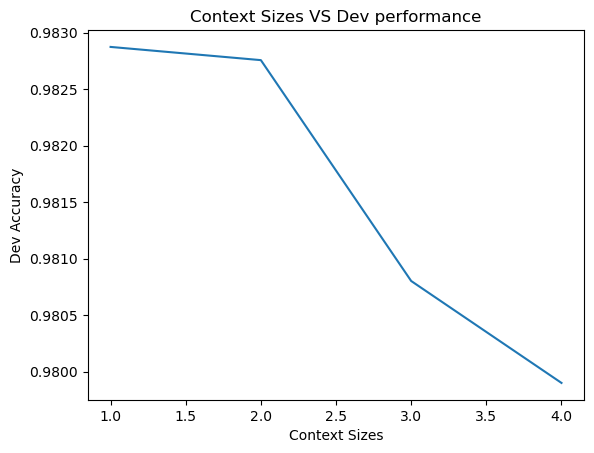

In [168]:
context_dev_perf = []
for context in context_size:
    acc = dev_performance[dev_performance['Context Size'] == context].iloc[0]['Accuracy']
    context_dev_perf.append(acc)
plt.plot(context_size, context_dev_perf)
plt.xlabel('Context Sizes')
plt.ylabel('Dev Accuracy')
plt.title('Context Sizes VS Dev performance')
plt.show()

Dev set performance
Context Size: 1, Hidden_layers: 2, Activation: relu, Accuracy: 0.9828, F1 Score: 0.9688, recall: 0.9828 


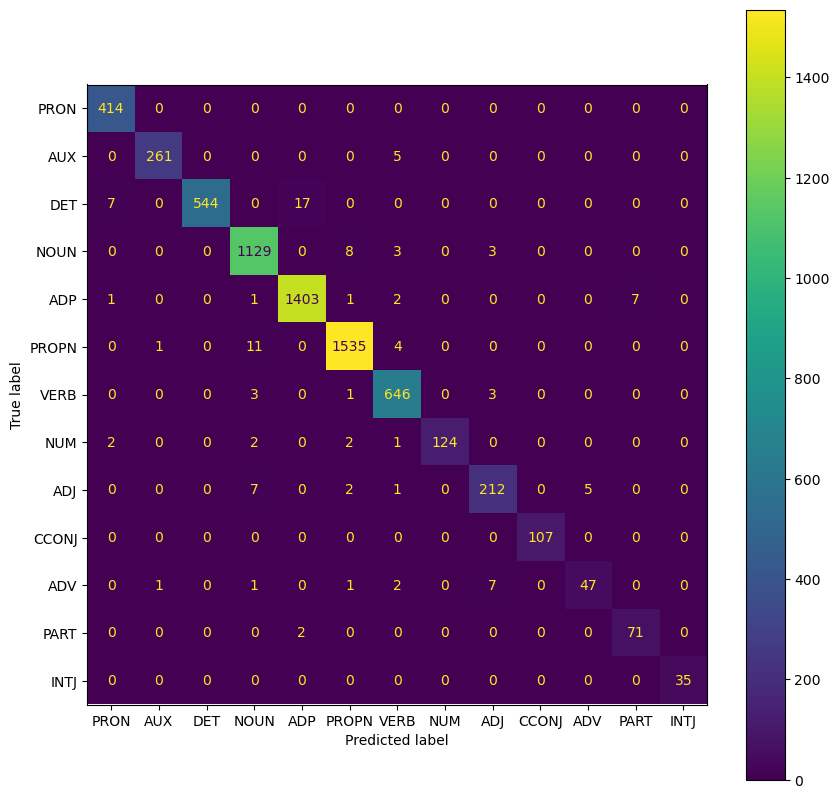


Test set performance
Context Size: 1, Hidden_layers: 2, Activation: relu, Accuracy: 0.9821, F1 Score: 0.9602, recall: 0.9821 


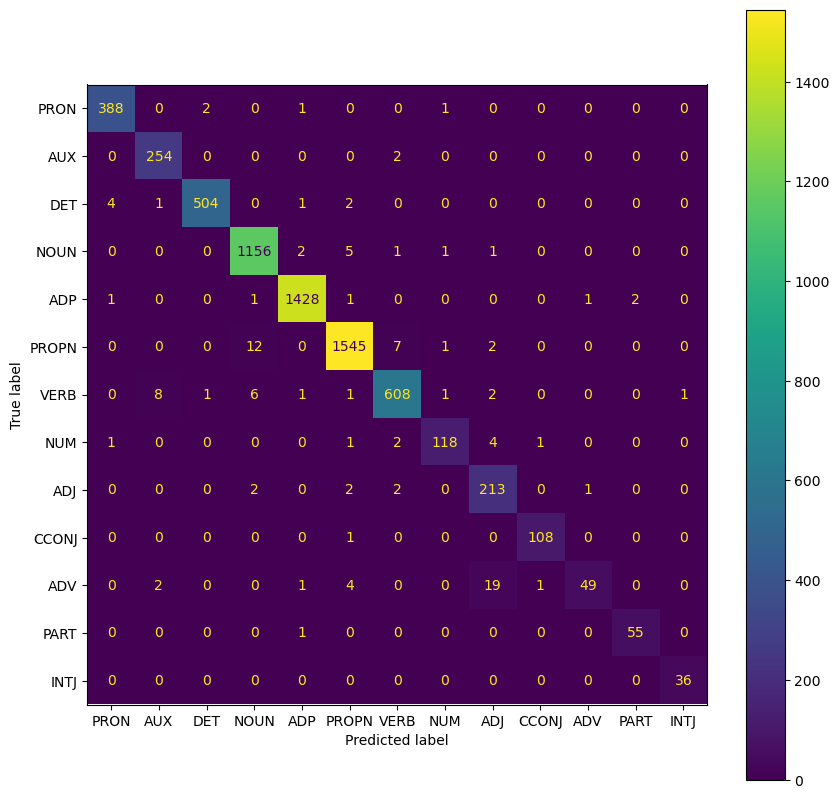

In [169]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
# test set performances
best = dev_performance.iloc[0]
layers = best['Hidden Layers']
context = best['Context Size']
activation = best['Activation']
idx = layers-1
act_idx = 0 if activation == 'relu' else 1
model = FeedForwardNN(len(vocab), embedding_dims,layers, hidden_dims[idx], len(pos_class),activation = activation, p = context, s = context)
model.load_state_dict(torch.load(f'./ffn/model_{context}_{idx}_{act_idx}.pth'))

print('Dev set performance')
with torch.no_grad():
    dev_data = CustomDataset(dev_sentences, p = context, s = context)
    dev_loader = DataLoader(dev_data, batch_size=32, shuffle=False)
    predictions = torch.tensor([])
    actual = torch.tensor([])
    acc = 0
    f1 = 0
    recall = 0
    for x, y in dev_loader:
        predict = model.predict(x)
#         accuracy = len(predict[predict ==  y]) / len(predict)
        predictions = torch.cat((predictions, predict))
        actual = torch.cat((actual, y))
    acc = accuracy_score(actual, predictions)
    f1 = f1_score(actual, predictions, average = 'macro', zero_division = 0)
    recall = recall_score(actual, predictions, average = 'weighted', zero_division = 0)
    print(f"Context Size: {context}, Hidden_layers: {layers}, Activation: {activation}, Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, recall: {recall:.4f} ")
    actual_class = [pos_class_rev[y.item()] for y in actual]
    predictions_class = [pos_class_rev[y.item()] for y in predictions]
    cm = confusion_matrix(actual_class, predictions_class, labels = list(pos_class.keys()))
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = list(pos_class.keys()))
    fig, ax = plt.subplots(figsize=(10,10))
    cm_display.plot(ax=ax)
    plt.show()
    
print('\nTest set performance')
with torch.no_grad():
    test_data = CustomDataset(test_sentences, p = context, s = context)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    predictions = torch.tensor([])
    actual = torch.tensor([])
    acc = 0
    f1 = 0
    recall = 0
    for x, y in test_loader:
        predict = model.predict(x)
#         accuracy = len(predict[predict ==  y]) / len(predict)
        predictions = torch.cat((predictions, predict))
        actual = torch.cat((actual, y))
    acc = accuracy_score(actual, predictions)
    f1 = f1_score(actual, predictions, average = 'macro', zero_division = 0)
    recall = recall_score(actual, predictions, average = 'weighted', zero_division = 0)
    print(f"Context Size: {context}, Hidden_layers: {layers}, Activation: {activation}, Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, recall: {recall:.4f} ")
    actual_class = [pos_class_rev[y.item()] for y in actual]
    predictions_class = [pos_class_rev[y.item()] for y in predictions]
    cm = confusion_matrix(actual_class, predictions_class, labels = list(pos_class.keys()))
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = list(pos_class.keys()))
    fig, ax = plt.subplots(figsize=(10,10))
    cm_display.plot(ax=ax)

In [178]:
best = dev_performance.iloc[0]
layers = best['Hidden Layers']
context = best['Context Size']
activation = best['Activation']
idx = layers-1
act_idx = 0 if activation == 'relu' else 1
model = FeedForwardNN(len(vocab), embedding_dims,layers, hidden_dims[idx], len(pos_class),activation = activation, p = context, s = context)
model.load_state_dict(torch.load(f'./ffn/model_{context}_{idx}_{act_idx}.pth'))

input_sentence = 'An apple a day'
test = tokenize(input_sentence, p = context, s = context)
predict = model.predict(test)
[pos_class_rev[pred.item()] for pred in predict]

['DET', 'VERB', 'DET', 'NOUN']